In [24]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Convolucion 1D (discreta)

$s(t) = \sum_{-\infty}^{\infty} x(a) \omega (t-a)$

$x$ : input \
$w$ : kernel \
$p$ : padding \
$s$ : stride

In [ ]:
def conv1D(x, w, p=0 , s=1): 
  '''

  '''
  assert len(w) <= len(x), "x debe ser mayor a w"
  assert p >= 0, "padding debe ser positivo"

  w_r = np.array(w[::-1]) #rotation of w 
  x_padded = np.array(x)

  if p > 0 :
    zeros = np.zeros(shape = p)
    x_padded = np.concatenate([zeros, x_padded, zeros]) #ceros hasta completar el padding

  out = []

  for i in range(0, int((len(x_padded) - len(w_r))) + 1 , s):
    out.append(np.sum(x_padded[i:i + w_r.shape[0]] * w_r))
  return np.array(out)

Test con datos

In [ ]:
x = [3,6,8,2,1,4,7,9]
w = [2 ,3, 6, 3, 2]
w= np.array(w)/np.max(w)

s = conv1D(x,w,2,1)

Visualizacion

In [ ]:
plt.figure(figsize=(12, 8))

# Graficar x
plt.subplot(3, 1, 1)
plt.stem(x, use_line_collection=True)
plt.title("Secuencia x")
plt.xlabel("Índice")
plt.ylabel("Valor")

# Graficar w
plt.subplot(3, 1, 2)
plt.stem(w, use_line_collection=True)
plt.title("Secuencia w (Kernel)")
plt.xlabel("Índice")
plt.ylabel("Valor")

# Graficar el resultado de la convolución
plt.subplot(3, 1, 3)
plt.stem(s, use_line_collection=True)
plt.title("Resultado de la Convolución")
plt.xlabel("Índice")
plt.ylabel("Valor")

plt.tight_layout()
plt.show()

# Convolucion 2D (Imagen)

$S(i,j) = (I*K) (i,j) = \sum_m \sum_n I(i-m,j-n) K(m,n)$

In [27]:
def conv2D(A, B):
    """
    Realizar una convolución 2D entre las matrices A y B.
    """
    # Dimensiones de las matrices
    a_rows, a_cols = A.shape
    b_rows, b_cols = B.shape

    # Matriz resultante con tamaño adecuado
    result = np.zeros((a_rows + b_rows - 1, a_cols + b_cols - 1))

    # Realizar la convolución
    for i in range(a_rows):
        for j in range(a_cols):
            result[i:i+b_rows, j:j+b_cols] += A[i, j] * B

    return result

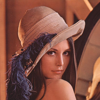

In [29]:
img = Image.open("ejemplo.jpg").resize((100,100))
img

In [30]:
A = np.array(img)
B = np.array([[1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]])